In [28]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


In [3]:
train_path = "./train/train"
# The glob module finds all the pathnames matching a specified pattern
train_pkl_lst = glob(os.path.join(train_path, '*'))
with open(train_pkl_lst[1], 'rb') as f:
    training_sample = pickle.load(f)

# LSTM

In [4]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        h_t, c_t = self.init_hidden(batch_size)

        #print(x.size())
        #print(x.size(-1))
        # Passing in the input and hidden state into the model and obtaining outputs
        out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, h_t
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 =  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)       
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return h_0, c_0

In [3]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [5]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        dat = np.concatenate((inp, out), axis=0)
        
        train_data = []
        window_size = 20
        interval = 7
        for i in range(0, len(dat), interval):
            #print(len(dat[i:i+input_length]))
            if i + window_size < len(dat): 
                train_data.append(dat[i:i+window_size])
            
        #print(len(train_data))
        #print(train_data)
        
        input_seq = []
        target_seq = []
        for i in range(len(train_data)):
            input_seq.append(train_data[i][:-1])
            target_seq.append(train_data[i][1:])
        
        #print(input_seq)
        
        input_seq = np.array(input_seq, dtype=np.float32)
        target_seq = np.array(target_seq, dtype=np.float32)
        
        #print(input_seq.shape)
        #print(target_seq.shape)
        
        # Convert to float torch tensor
        #return torch.from_numpy(inp).float(), torch.from_numpy(out).float() #torch.from_numpy(out[:,:2]).float()
        return torch.from_numpy(input_seq).float(), torch.from_numpy(target_seq).float()

In [6]:
training_sample['p_out'].shape

(60, 30, 2)

In [7]:
training_sample['v_out'].shape

(60, 30, 2)

In [5]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [6]:
# Grid/Random Search

In [22]:
# batch_size = 64
interval = 7 # sampling interval for LSTM
window_size = 20 # number of timesteps to take as input
batch_size = 512
#in_dim = 19*4 # MLP
#out_dim = 4 #30*2 # MLP
input_size = 4 # LSTM
output_size = 4 # LSTM (has to match input_size)
hidden_dim = 128 #32 #128
num_layers = 1 #3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [23]:
train_path = "./train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [18]:
len(train_set)

180000

In [80]:
# train_set[0]

In [19]:
len(train_loader)

352

# Model, Loss Function and Optimizer

In [20]:
# # RNN, LSTM, 1dCNN, Transformer
# model = MLPNet(in_dim = in_dim, 
#                out_dim = out_dim,
#                hidden_dim = hidden_dim, 
#                num_layers = num_layers).to(device) # move model to gpu 

model = MyLSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=num_layers).to(device)

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [9]:
model.load_state_dict(torch.load('baseline.pt'))

<All keys matched successfully>

In [118]:
# train_path = "./train/train/"
# train_pkl_list = glob(os.path.join(train_path, '*'))
# train_pkl_list.sort()

# train_preds = []
# for idx in range(3):
#     with open(train_pkl_list[idx], 'rb') as f:
#         train_sample = pickle.load(f)
#         pred_id = np.where(train_sample["track_id"] == train_sample['agent_id'])[0][0]
#         inp_scene = np.dstack([train_sample['p_in'], train_sample['v_in']])

#         # Normalization 
#         min_vecs = np.min(inp_scene, axis = (0,1))
#         max_vecs = np.max(inp_scene, axis = (0,1))
        
#         inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
#         inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

#         preds = model(inp).cpu().data.numpy()
        
#         # De-Normalization ! 
#         preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
#         train_preds.append(preds)

# Training

In [171]:
for inp, tgt in train_loader:
    print(inp.shape)
    print(tgt.shape)
    print(inp.view(-1, window_size-1, 4).size()) 
    print(inp[0, 0, :, :])
    break
        

torch.Size([512, 5, 19, 4])
torch.Size([512, 5, 19, 4])
torch.Size([2560, 19, 4])
tensor([[1.0000, 1.0000, 0.0566, 0.0473],
        [0.9998, 0.9996, 0.0643, 0.0610],
        [0.9995, 0.9992, 0.0543, 0.0229],
        [0.9993, 0.9988, 0.1135, 0.1166],
        [0.9991, 0.9984, 0.0722, 0.0608],
        [0.9989, 0.9981, 0.1136, 0.1087],
        [0.9987, 0.9977, 0.0845, 0.0779],
        [0.9984, 0.9973, 0.0762, 0.0627],
        [0.9982, 0.9969, 0.0633, 0.0508],
        [0.9980, 0.9965, 0.0501, 0.0407],
        [0.9978, 0.9962, 0.1454, 0.1404],
        [0.9975, 0.9957, 0.0430, 0.0333],
        [0.9973, 0.9954, 0.1270, 0.1274],
        [0.9971, 0.9950, 0.0749, 0.0670],
        [0.9969, 0.9946, 0.0619, 0.0524],
        [0.9966, 0.9942, 0.0747, 0.0485],
        [0.9964, 0.9938, 0.0602, 0.0563],
        [0.9962, 0.9935, 0.1179, 0.1185],
        [0.9959, 0.9930, 0.0306, 0.0269]])


In [142]:
def train_epoch(train_loader, model, optimizer, loss_function):

    train_mse = []
    for inp, tgt in tqdm(train_loader):
        
        inp = inp.view(-1, window_size-1, 4)
        tgt = tgt.view(-1, window_size-1, 4)
        
        #print(inp.size())
        
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        output, hidden = model(inp)
        output = output.to(device)
        #print(output.shape)
        #print(hidden.shape)
        #print(tgt.view(-1, 4).size())
        
        loss = loss_function(output, tgt.view(-1, 4))
        train_mse.append(loss.item()) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    
    valid_mse = []
    #preds = []
    #trues = []
    
    with torch.no_grad():
        for inp, tgt in valid_loader:
            
            inp = inp.view(-1, window_size-1, 4)
            tgt = tgt.view(-1, window_size-1, 4)
            
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            output, hidden = model(inp)
            output = output.to(device)
                    
            loss = loss_function(output, tgt.view(-1, 4))
            
            #preds.append(pred.cpu().data.numpy())
            #trues.append(tgt.cpu().data.numpy())
            
            valid_mse.append(loss.item())
            
        #preds = np.concatenate(preds, axis = 0)  
        #trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse#, preds, trues


In [14]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

 88%|████████▊ | 309/352 [03:47<00:32,  1.32it/s]


100%|██████████| 352/352 [04:21<00:00,  1.35it/s]


[0.10935]
0.109
Epoch 1 | T: 5.03 | Train RMSE: 0.10935 | Valid RMSE: 0.10900


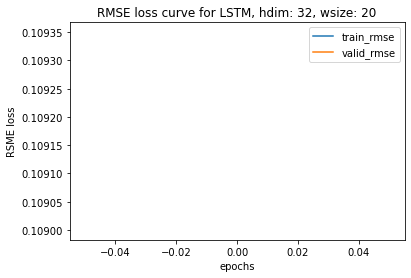

 88%|████████▊ | 308/352 [03:56<00:34,  1.28it/s]


100%|██████████| 352/352 [04:31<00:00,  1.30it/s]


[0.10935, 0.10927]
0.10871
Epoch 2 | T: 5.18 | Train RMSE: 0.10927 | Valid RMSE: 0.10871


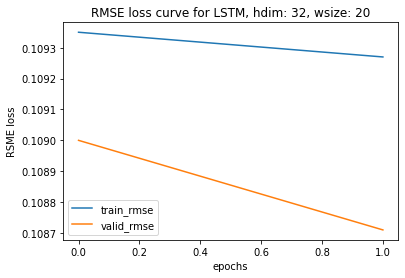

 88%|████████▊ | 308/352 [03:57<00:34,  1.26it/s]


100%|██████████| 352/352 [04:32<00:00,  1.29it/s]


[0.10935, 0.10927, 0.10919]
0.1087
Epoch 3 | T: 5.19 | Train RMSE: 0.10919 | Valid RMSE: 0.10870


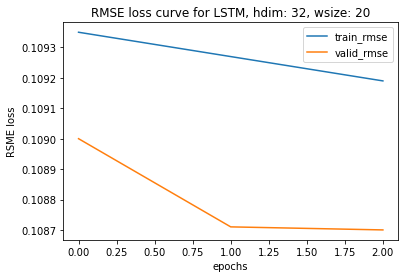

 88%|████████▊ | 308/352 [03:50<00:33,  1.30it/s]


100%|██████████| 352/352 [04:24<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091]
0.10864
Epoch 4 | T: 5.06 | Train RMSE: 0.10910 | Valid RMSE: 0.10864


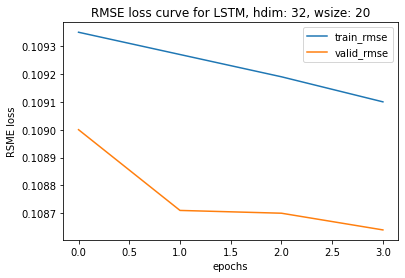

 88%|████████▊ | 308/352 [03:50<00:34,  1.27it/s]


100%|██████████| 352/352 [04:25<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905]
0.1086
Epoch 5 | T: 5.07 | Train RMSE: 0.10905 | Valid RMSE: 0.10860


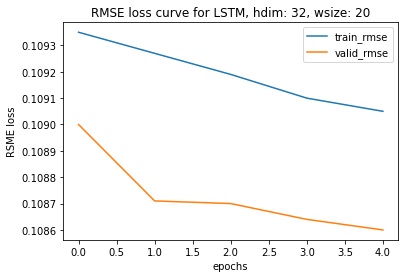

 88%|████████▊ | 308/352 [03:54<00:34,  1.26it/s]


100%|██████████| 352/352 [04:29<00:00,  1.31it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897]
0.10846
Epoch 6 | T: 5.16 | Train RMSE: 0.10897 | Valid RMSE: 0.10846


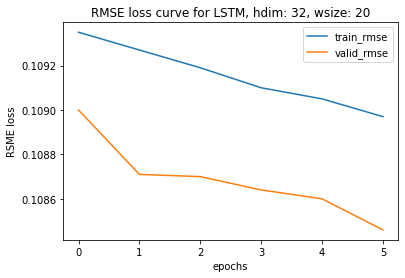

 88%|████████▊ | 308/352 [03:44<00:34,  1.29it/s]


100%|██████████| 352/352 [04:17<00:00,  1.37it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089]
0.10844
Epoch 7 | T: 4.91 | Train RMSE: 0.10890 | Valid RMSE: 0.10844


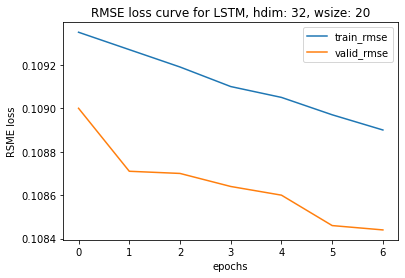

 88%|████████▊ | 308/352 [03:40<00:30,  1.43it/s]


100%|██████████| 352/352 [04:13<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883]
0.10848
Epoch 8 | T: 4.83 | Train RMSE: 0.10883 | Valid RMSE: 0.10848


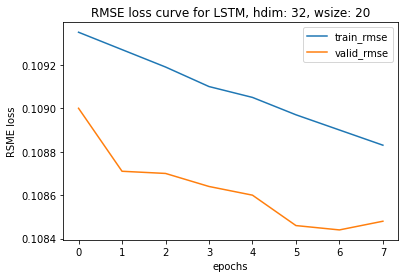

 88%|████████▊ | 308/352 [03:47<00:32,  1.34it/s]


100%|██████████| 352/352 [04:21<00:00,  1.35it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877]
0.1084
Epoch 9 | T: 4.96 | Train RMSE: 0.10877 | Valid RMSE: 0.10840


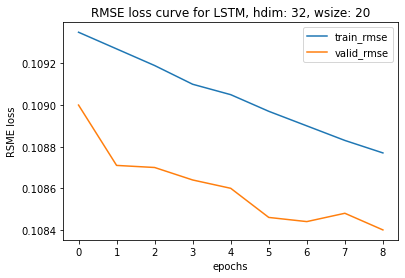

 88%|████████▊ | 308/352 [03:45<00:33,  1.31it/s]


100%|██████████| 352/352 [04:19<00:00,  1.36it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871]
0.10839
Epoch 10 | T: 4.95 | Train RMSE: 0.10871 | Valid RMSE: 0.10839


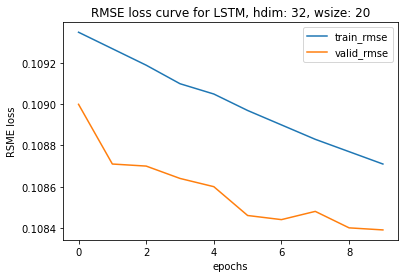

 88%|████████▊ | 308/352 [03:51<00:33,  1.31it/s]


100%|██████████| 352/352 [04:25<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868]
0.1083
Epoch 11 | T: 5.06 | Train RMSE: 0.10868 | Valid RMSE: 0.10830


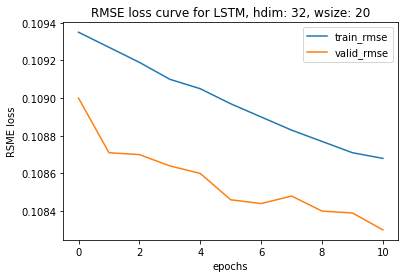

 88%|████████▊ | 308/352 [03:48<00:32,  1.36it/s]


100%|██████████| 352/352 [04:21<00:00,  1.35it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861]
0.10816
Epoch 12 | T: 4.99 | Train RMSE: 0.10861 | Valid RMSE: 0.10816


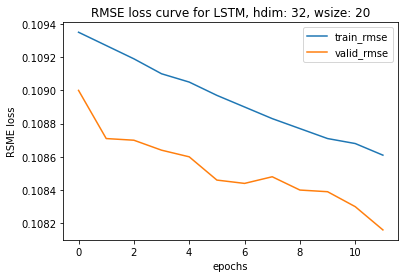

 88%|████████▊ | 308/352 [03:48<00:33,  1.31it/s]


100%|██████████| 352/352 [04:23<00:00,  1.34it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854]
0.10816
Epoch 13 | T: 5.02 | Train RMSE: 0.10854 | Valid RMSE: 0.10816


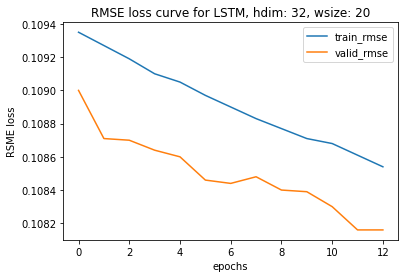

 88%|████████▊ | 308/352 [03:46<00:34,  1.28it/s]


100%|██████████| 352/352 [04:20<00:00,  1.35it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852]
0.10814
Epoch 14 | T: 4.98 | Train RMSE: 0.10852 | Valid RMSE: 0.10814


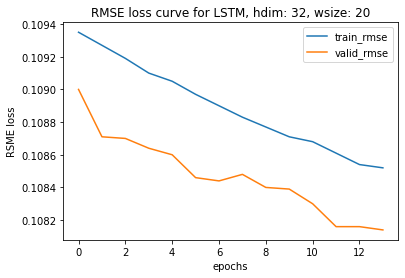

 88%|████████▊ | 308/352 [03:50<00:34,  1.28it/s]


100%|██████████| 352/352 [04:25<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851]
0.10809
Epoch 15 | T: 5.06 | Train RMSE: 0.10851 | Valid RMSE: 0.10809


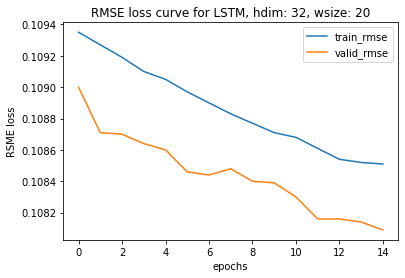

 88%|████████▊ | 308/352 [03:52<00:34,  1.27it/s]


100%|██████████| 352/352 [04:26<00:00,  1.32it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846]
0.10813
Epoch 16 | T: 5.09 | Train RMSE: 0.10846 | Valid RMSE: 0.10813


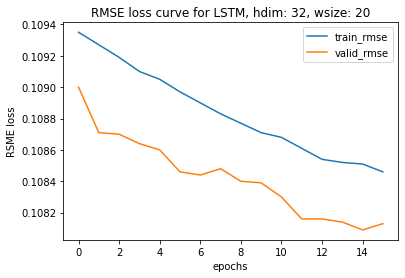

 88%|████████▊ | 308/352 [03:52<00:34,  1.27it/s]


100%|██████████| 352/352 [04:26<00:00,  1.32it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084]
0.10812
Epoch 17 | T: 5.10 | Train RMSE: 0.10840 | Valid RMSE: 0.10812


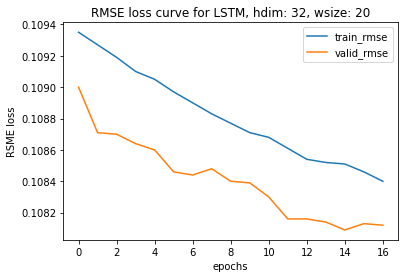

 88%|████████▊ | 308/352 [03:50<00:33,  1.30it/s]


100%|██████████| 352/352 [04:25<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836]
0.10809
Epoch 18 | T: 5.07 | Train RMSE: 0.10836 | Valid RMSE: 0.10809


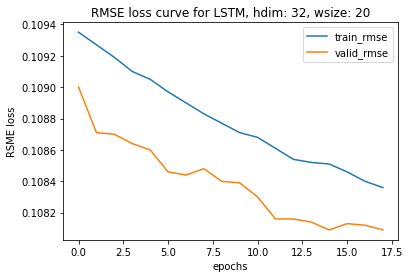

 88%|████████▊ | 308/352 [03:50<00:31,  1.39it/s]


100%|██████████| 352/352 [04:24<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834]
0.10801
Epoch 19 | T: 5.08 | Train RMSE: 0.10834 | Valid RMSE: 0.10801


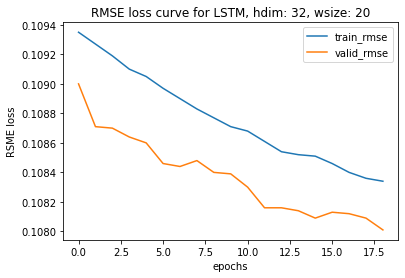

 88%|████████▊ | 308/352 [03:57<00:35,  1.23it/s]


100%|██████████| 352/352 [04:31<00:00,  1.30it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832]
0.10803
Epoch 20 | T: 5.19 | Train RMSE: 0.10832 | Valid RMSE: 0.10803


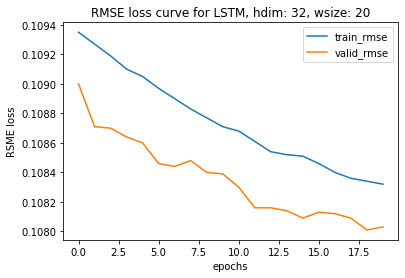

 88%|████████▊ | 308/352 [03:59<00:35,  1.23it/s]


100%|██████████| 352/352 [04:33<00:00,  1.29it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829]
0.10794
Epoch 21 | T: 5.23 | Train RMSE: 0.10829 | Valid RMSE: 0.10794


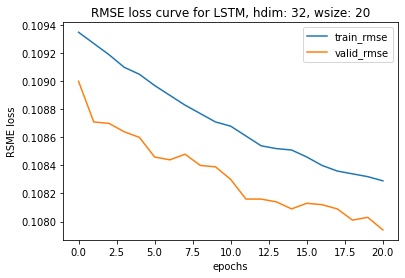

 88%|████████▊ | 308/352 [03:57<00:34,  1.26it/s]


100%|██████████| 352/352 [04:32<00:00,  1.29it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827]
0.10794
Epoch 22 | T: 5.21 | Train RMSE: 0.10827 | Valid RMSE: 0.10794


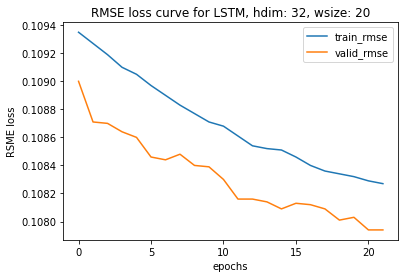

 88%|████████▊ | 308/352 [04:00<00:36,  1.22it/s]


100%|██████████| 352/352 [04:35<00:00,  1.28it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826]
0.10792
Epoch 23 | T: 5.27 | Train RMSE: 0.10826 | Valid RMSE: 0.10792


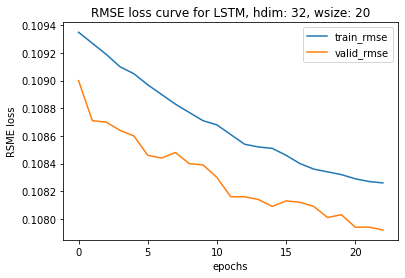

 88%|████████▊ | 308/352 [04:00<00:36,  1.20it/s]


100%|██████████| 352/352 [04:36<00:00,  1.27it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821]
0.10803
Epoch 24 | T: 5.27 | Train RMSE: 0.10821 | Valid RMSE: 0.10803


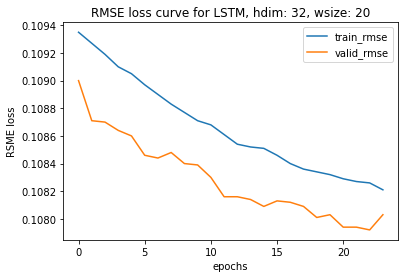

 88%|████████▊ | 308/352 [03:59<00:34,  1.29it/s]


100%|██████████| 352/352 [04:35<00:00,  1.28it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819]
0.10802
Epoch 25 | T: 5.26 | Train RMSE: 0.10819 | Valid RMSE: 0.10802


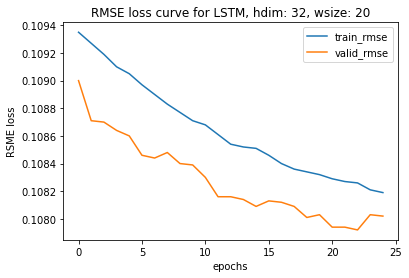

 88%|████████▊ | 308/352 [03:58<00:35,  1.24it/s]


100%|██████████| 352/352 [04:34<00:00,  1.28it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818]
0.10783
Epoch 26 | T: 5.24 | Train RMSE: 0.10818 | Valid RMSE: 0.10783


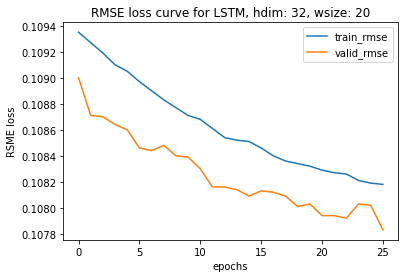

 88%|████████▊ | 308/352 [03:51<00:35,  1.26it/s]


100%|██████████| 352/352 [04:25<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815]
0.10785
Epoch 27 | T: 5.07 | Train RMSE: 0.10815 | Valid RMSE: 0.10785


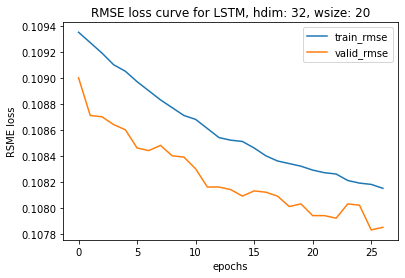

 88%|████████▊ | 308/352 [03:56<00:35,  1.25it/s]


100%|██████████| 352/352 [04:31<00:00,  1.30it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812]
0.10796
Epoch 28 | T: 5.20 | Train RMSE: 0.10812 | Valid RMSE: 0.10796


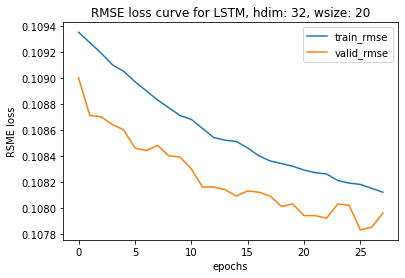

 88%|████████▊ | 308/352 [04:00<00:36,  1.20it/s]


100%|██████████| 352/352 [04:35<00:00,  1.28it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811]
0.1078
Epoch 29 | T: 5.28 | Train RMSE: 0.10811 | Valid RMSE: 0.10780


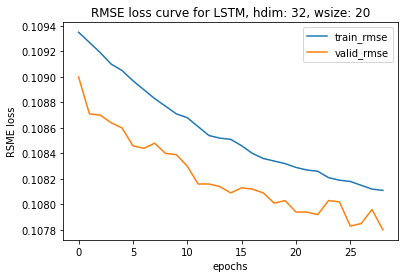

 88%|████████▊ | 308/352 [04:00<00:34,  1.28it/s]


100%|██████████| 352/352 [04:35<00:00,  1.28it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081]
0.10785
Epoch 30 | T: 5.26 | Train RMSE: 0.10810 | Valid RMSE: 0.10785


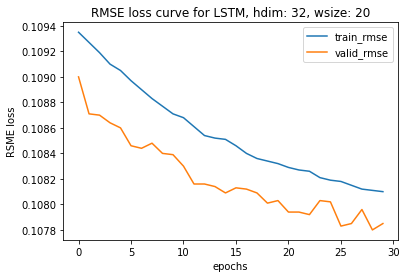

 88%|████████▊ | 308/352 [04:00<00:34,  1.26it/s]


100%|██████████| 352/352 [04:34<00:00,  1.28it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808]
0.10785
Epoch 31 | T: 5.25 | Train RMSE: 0.10808 | Valid RMSE: 0.10785


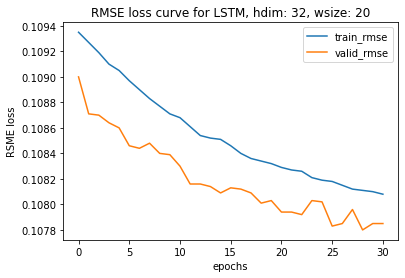

 88%|████████▊ | 308/352 [04:00<00:35,  1.25it/s]


100%|██████████| 352/352 [04:35<00:00,  1.28it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806]
0.10777
Epoch 32 | T: 5.24 | Train RMSE: 0.10806 | Valid RMSE: 0.10777


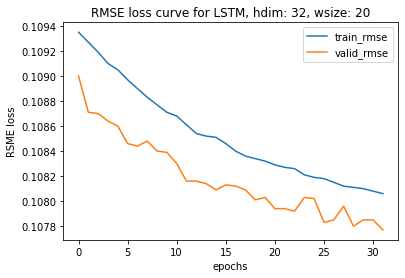

 88%|████████▊ | 308/352 [03:56<00:34,  1.27it/s]


100%|██████████| 352/352 [04:31<00:00,  1.30it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804]
0.10776
Epoch 33 | T: 5.18 | Train RMSE: 0.10804 | Valid RMSE: 0.10776


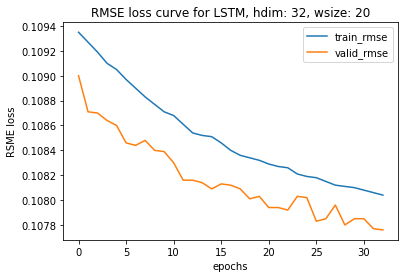

 88%|████████▊ | 308/352 [03:51<00:36,  1.21it/s]


100%|██████████| 352/352 [04:26<00:00,  1.32it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802]
0.10774
Epoch 34 | T: 5.11 | Train RMSE: 0.10802 | Valid RMSE: 0.10774


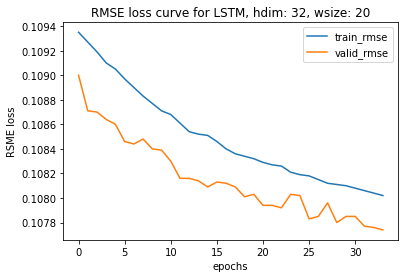

 88%|████████▊ | 308/352 [03:59<00:33,  1.31it/s]


100%|██████████| 352/352 [04:34<00:00,  1.28it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801]
0.10779
Epoch 35 | T: 5.19 | Train RMSE: 0.10801 | Valid RMSE: 0.10779


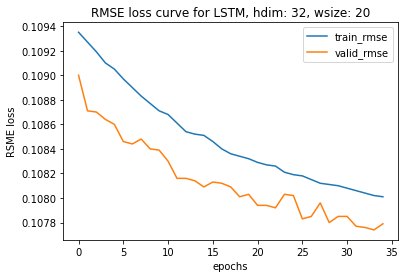

 88%|████████▊ | 308/352 [03:49<00:32,  1.37it/s]


100%|██████████| 352/352 [04:23<00:00,  1.34it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799]
0.10776
Epoch 36 | T: 5.03 | Train RMSE: 0.10799 | Valid RMSE: 0.10776


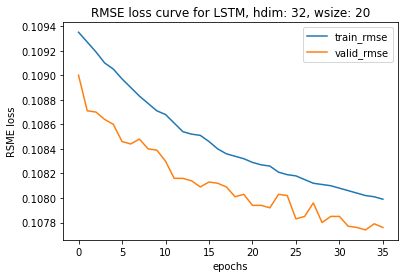

 88%|████████▊ | 308/352 [03:49<00:31,  1.39it/s]


100%|██████████| 352/352 [04:20<00:00,  1.35it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108]
0.10776
Epoch 37 | T: 4.96 | Train RMSE: 0.10800 | Valid RMSE: 0.10776


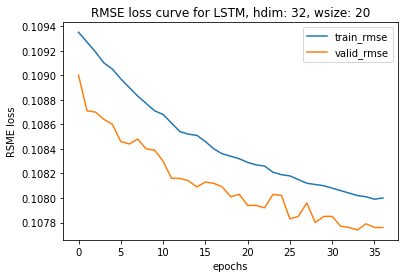

 69%|██████▉   | 243/352 [02:51<01:17,  1.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 49%|████▉     | 173/352 [02:11<02:20,  1.27it/s]


100%|██████████| 352/352 [04:33<00:00,  1.29it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793]
0.10769
Epoch 43 | T: 5.21 | Train RMSE: 0.10793 | Valid RMSE: 0.10769


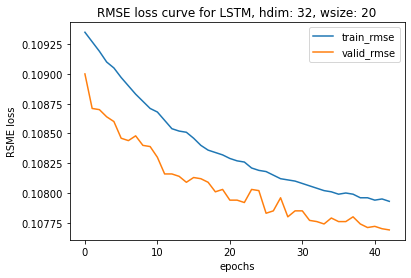

 88%|████████▊ | 308/352 [03:57<00:36,  1.20it/s]


100%|██████████| 352/352 [04:30<00:00,  1.30it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791]
0.10769
Epoch 44 | T: 5.14 | Train RMSE: 0.10791 | Valid RMSE: 0.10769


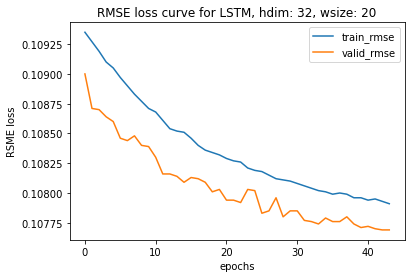

 88%|████████▊ | 308/352 [03:36<00:31,  1.39it/s]


100%|██████████| 352/352 [04:10<00:00,  1.41it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793]
0.10767
Epoch 45 | T: 4.77 | Train RMSE: 0.10793 | Valid RMSE: 0.10767


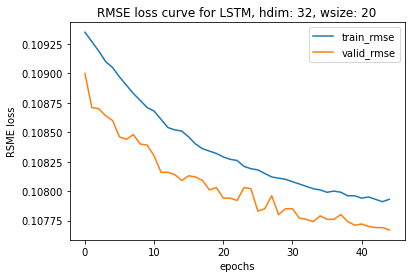

 88%|████████▊ | 308/352 [03:36<00:30,  1.42it/s]


100%|██████████| 352/352 [04:08<00:00,  1.42it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079]
0.10768
Epoch 46 | T: 4.80 | Train RMSE: 0.10790 | Valid RMSE: 0.10768


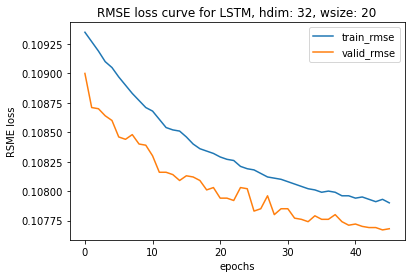

 88%|████████▊ | 308/352 [03:52<00:32,  1.37it/s]


100%|██████████| 352/352 [04:24<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789]
0.10766
Epoch 47 | T: 5.00 | Train RMSE: 0.10789 | Valid RMSE: 0.10766


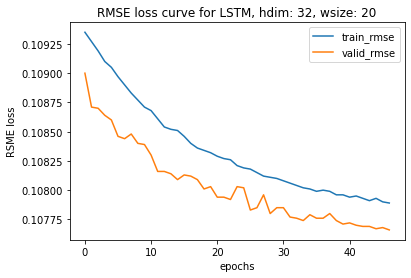

 88%|████████▊ | 308/352 [03:37<00:30,  1.44it/s]


100%|██████████| 352/352 [04:09<00:00,  1.41it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789]
0.10766
Epoch 48 | T: 4.76 | Train RMSE: 0.10789 | Valid RMSE: 0.10766


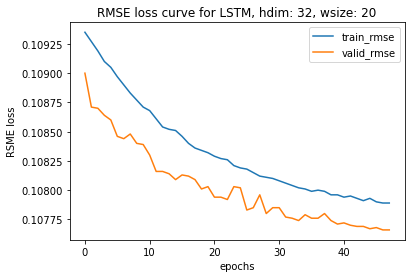

 88%|████████▊ | 308/352 [03:41<00:31,  1.41it/s]


100%|██████████| 352/352 [04:12<00:00,  1.40it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787]
0.10766
Epoch 49 | T: 4.83 | Train RMSE: 0.10787 | Valid RMSE: 0.10766


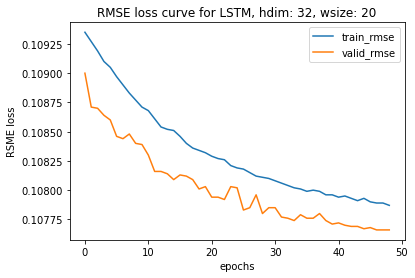

 88%|████████▊ | 308/352 [03:38<00:33,  1.31it/s]


100%|██████████| 352/352 [04:10<00:00,  1.41it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786]
0.10764
Epoch 50 | T: 4.77 | Train RMSE: 0.10786 | Valid RMSE: 0.10764


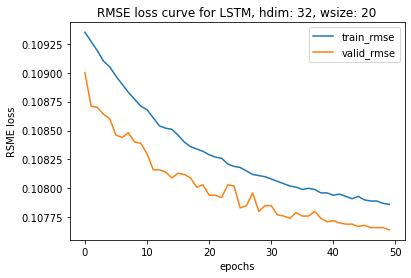

 88%|████████▊ | 308/352 [03:37<00:30,  1.43it/s]


100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785]
0.10768
Epoch 51 | T: 4.81 | Train RMSE: 0.10785 | Valid RMSE: 0.10768


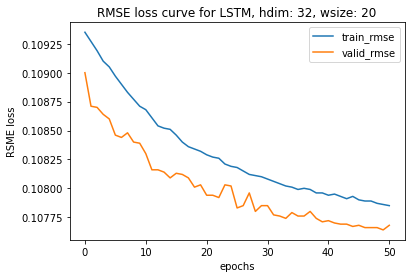

 88%|████████▊ | 308/352 [03:52<00:32,  1.34it/s]


100%|██████████| 352/352 [04:26<00:00,  1.32it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785]
0.10764
Epoch 52 | T: 5.10 | Train RMSE: 0.10785 | Valid RMSE: 0.10764


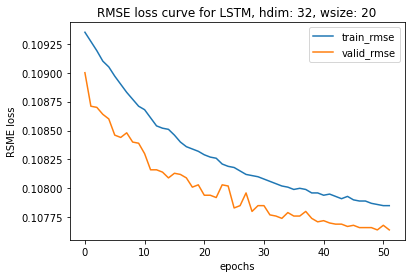

 88%|████████▊ | 308/352 [03:49<00:32,  1.36it/s]


100%|██████████| 352/352 [04:22<00:00,  1.34it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785]
0.10764
Epoch 53 | T: 5.01 | Train RMSE: 0.10785 | Valid RMSE: 0.10764


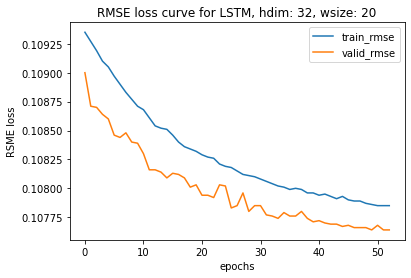

 88%|████████▊ | 308/352 [03:49<00:34,  1.26it/s]


100%|██████████| 352/352 [04:22<00:00,  1.34it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785]
0.10765
Epoch 54 | T: 5.01 | Train RMSE: 0.10785 | Valid RMSE: 0.10765


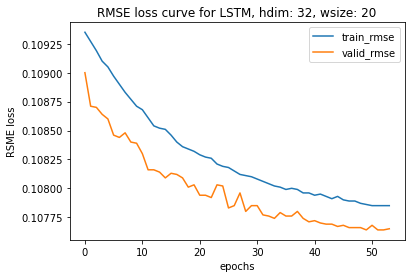

 88%|████████▊ | 308/352 [03:47<00:33,  1.31it/s]


100%|██████████| 352/352 [04:20<00:00,  1.35it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784]
0.10764
Epoch 55 | T: 4.96 | Train RMSE: 0.10784 | Valid RMSE: 0.10764


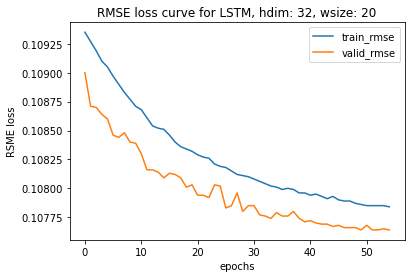

 88%|████████▊ | 308/352 [03:50<00:34,  1.26it/s]


100%|██████████| 352/352 [04:25<00:00,  1.32it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785]
0.10762
Epoch 56 | T: 5.09 | Train RMSE: 0.10785 | Valid RMSE: 0.10762


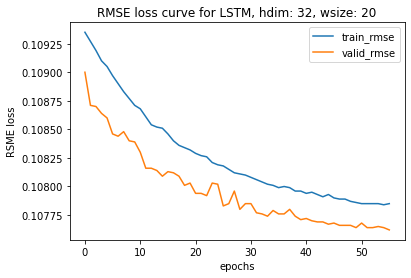

 88%|████████▊ | 308/352 [03:55<00:34,  1.28it/s]


100%|██████████| 352/352 [04:29<00:00,  1.31it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782]
0.10764
Epoch 57 | T: 5.13 | Train RMSE: 0.10782 | Valid RMSE: 0.10764


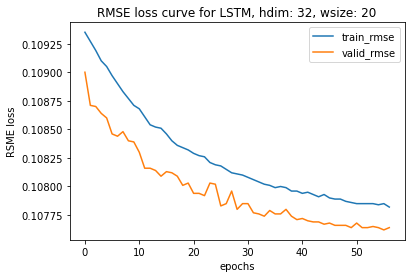

 88%|████████▊ | 308/352 [03:52<00:33,  1.31it/s]


100%|██████████| 352/352 [04:26<00:00,  1.32it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783]
0.10762
Epoch 58 | T: 5.08 | Train RMSE: 0.10783 | Valid RMSE: 0.10762


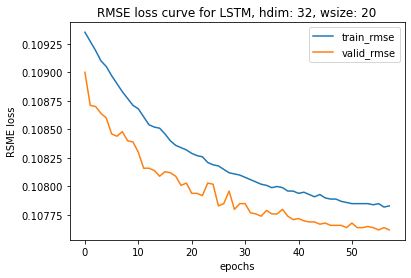

 88%|████████▊ | 308/352 [03:45<00:42,  1.03it/s]


100%|██████████| 352/352 [04:20<00:00,  1.35it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782]
0.10763
Epoch 59 | T: 4.95 | Train RMSE: 0.10782 | Valid RMSE: 0.10763


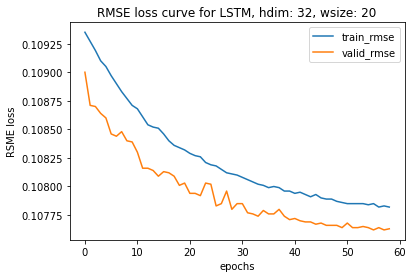

 88%|████████▊ | 308/352 [03:48<00:31,  1.41it/s]


100%|██████████| 352/352 [04:19<00:00,  1.36it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781]
0.10762
Epoch 60 | T: 4.93 | Train RMSE: 0.10781 | Valid RMSE: 0.10762


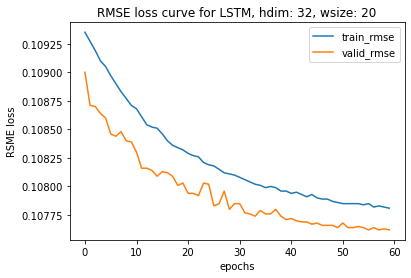

 88%|████████▊ | 308/352 [03:52<00:31,  1.38it/s]


100%|██████████| 352/352 [04:25<00:00,  1.33it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782]
0.10762
Epoch 61 | T: 5.06 | Train RMSE: 0.10782 | Valid RMSE: 0.10762


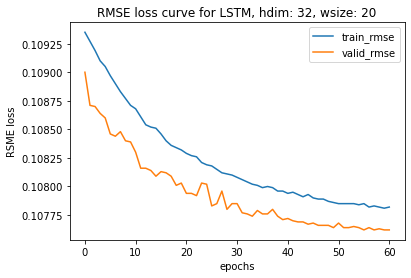

 88%|████████▊ | 308/352 [03:46<00:32,  1.35it/s]


100%|██████████| 352/352 [04:18<00:00,  1.36it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779]
0.10761
Epoch 62 | T: 4.93 | Train RMSE: 0.10779 | Valid RMSE: 0.10761


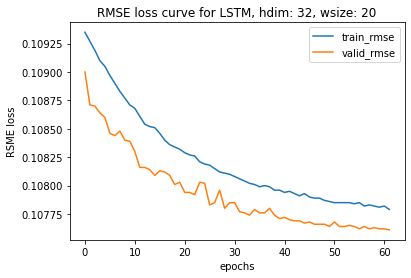

 88%|████████▊ | 308/352 [03:42<00:32,  1.35it/s]


100%|██████████| 352/352 [04:15<00:00,  1.38it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779]
0.10761
Epoch 63 | T: 4.87 | Train RMSE: 0.10779 | Valid RMSE: 0.10761


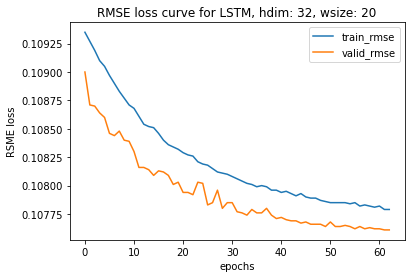

 88%|████████▊ | 308/352 [03:41<00:31,  1.39it/s]


100%|██████████| 352/352 [04:13<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078]
0.1076
Epoch 64 | T: 4.84 | Train RMSE: 0.10780 | Valid RMSE: 0.10760


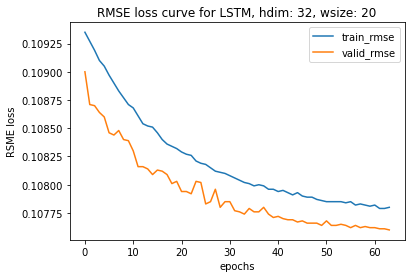

 88%|████████▊ | 308/352 [03:41<00:33,  1.33it/s]


100%|██████████| 352/352 [04:13<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783]
0.1076
Epoch 65 | T: 4.83 | Train RMSE: 0.10783 | Valid RMSE: 0.10760


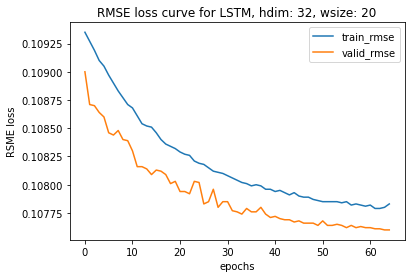

 88%|████████▊ | 308/352 [03:42<00:32,  1.37it/s]


100%|██████████| 352/352 [04:13<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779]
0.1076
Epoch 66 | T: 4.84 | Train RMSE: 0.10779 | Valid RMSE: 0.10760


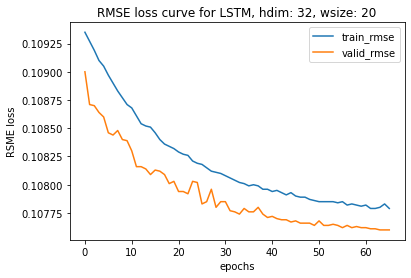

 88%|████████▊ | 308/352 [03:41<00:31,  1.38it/s]


100%|██████████| 352/352 [04:14<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779]
0.1076
Epoch 67 | T: 4.85 | Train RMSE: 0.10779 | Valid RMSE: 0.10760


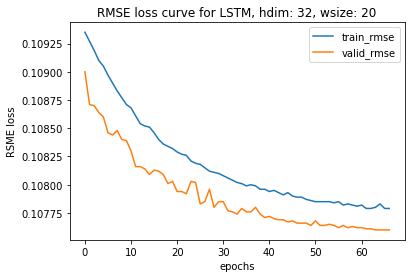

 88%|████████▊ | 308/352 [03:42<00:33,  1.31it/s]


100%|██████████| 352/352 [04:14<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779, 0.10781]
0.10759
Epoch 68 | T: 4.84 | Train RMSE: 0.10781 | Valid RMSE: 0.10759


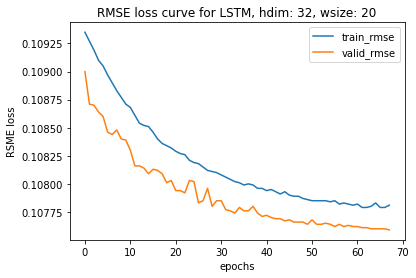

 88%|████████▊ | 309/352 [03:41<00:29,  1.44it/s]


100%|██████████| 352/352 [04:12<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779, 0.10781, 0.10777]
0.10759
Epoch 69 | T: 4.79 | Train RMSE: 0.10777 | Valid RMSE: 0.10759


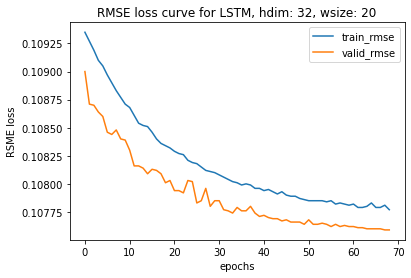

 88%|████████▊ | 308/352 [03:40<00:31,  1.39it/s]


100%|██████████| 352/352 [04:12<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779, 0.10781, 0.10777, 0.10778]
0.10758
Epoch 70 | T: 4.84 | Train RMSE: 0.10778 | Valid RMSE: 0.10758


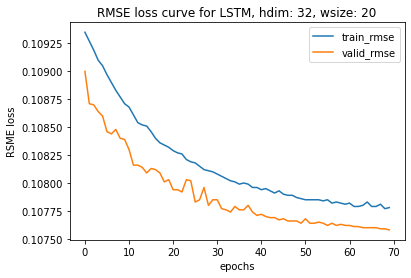

 88%|████████▊ | 308/352 [03:40<00:32,  1.36it/s]


 89%|████████▉ | 313/352 [03:44<00:28,  1.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


100%|██████████| 352/352 [04:12<00:00,  1.39it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779, 0.10781, 0.10777, 0.10778, 0.10776, 0.10776, 0.10777, 0.10777, 0.10777]
0.10758
Epoch 75 | T: 4.80 | Train RMSE: 0.10777 | Valid RMSE: 0.10758


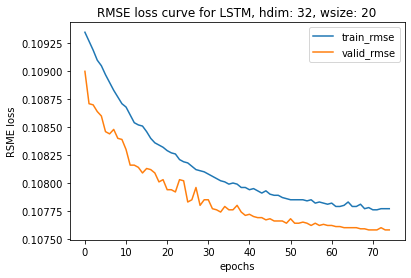

 88%|████████▊ | 308/352 [03:36<00:32,  1.34it/s]


100%|██████████| 352/352 [04:08<00:00,  1.42it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779, 0.10781, 0.10777, 0.10778, 0.10776, 0.10776, 0.10777, 0.10777, 0.10777, 0.10776]
0.10757
Epoch 76 | T: 4.75 | Train RMSE: 0.10776 | Valid RMSE: 0.10757


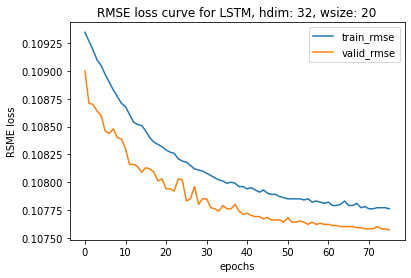

 88%|████████▊ | 308/352 [03:39<00:32,  1.37it/s]


100%|██████████| 352/352 [04:10<00:00,  1.40it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779, 0.10781, 0.10777, 0.10778, 0.10776, 0.10776, 0.10777, 0.10777, 0.10777, 0.10776, 0.10775]
0.10758
Epoch 77 | T: 4.80 | Train RMSE: 0.10775 | Valid RMSE: 0.10758


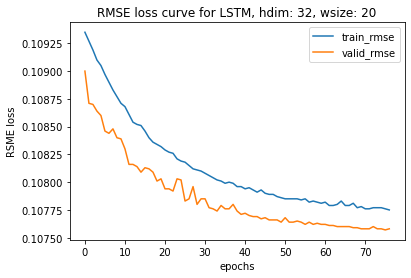

 80%|███████▉  | 280/352 [03:21<00:52,  1.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.10757
Epoch 78 | T: 4.83 | Train RMSE: 0.10776 | Valid RMSE: 0.10757



100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779, 0.10781, 0.10777, 0.10778, 0.10776, 0.10776, 0.10777, 0.10777, 0.10777, 0.10776, 0.10775, 0.10776, 0.10777]
0.10757
Epoch 79 | T: 4.78 | Train RMSE: 0.10777 | Valid RMSE: 0.10757


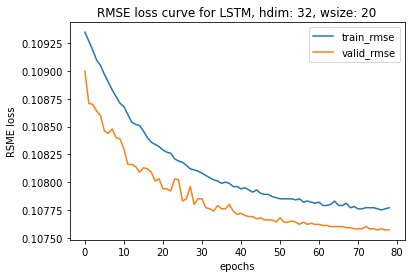

 88%|████████▊ | 308/352 [03:37<00:31,  1.41it/s]


100%|██████████| 352/352 [04:09<00:00,  1.41it/s]


[0.10935, 0.10927, 0.10919, 0.1091, 0.10905, 0.10897, 0.1089, 0.10883, 0.10877, 0.10871, 0.10868, 0.10861, 0.10854, 0.10852, 0.10851, 0.10846, 0.1084, 0.10836, 0.10834, 0.10832, 0.10829, 0.10827, 0.10826, 0.10821, 0.10819, 0.10818, 0.10815, 0.10812, 0.10811, 0.1081, 0.10808, 0.10806, 0.10804, 0.10802, 0.10801, 0.10799, 0.108, 0.10799, 0.10796, 0.10796, 0.10794, 0.10795, 0.10793, 0.10791, 0.10793, 0.1079, 0.10789, 0.10789, 0.10787, 0.10786, 0.10785, 0.10785, 0.10785, 0.10785, 0.10784, 0.10785, 0.10782, 0.10783, 0.10782, 0.10781, 0.10782, 0.10779, 0.10779, 0.1078, 0.10783, 0.10779, 0.10779, 0.10781, 0.10777, 0.10778, 0.10776, 0.10776, 0.10777, 0.10777, 0.10777, 0.10776, 0.10775, 0.10776, 0.10777, 0.10777]
0.10757
Epoch 80 | T: 4.77 | Train RMSE: 0.10777 | Valid RMSE: 0.10757


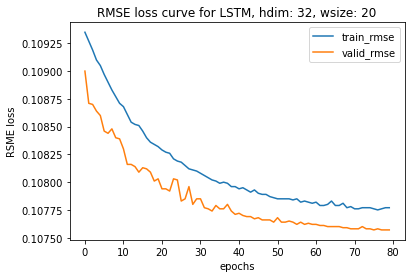

 38%|███▊      | 134/352 [01:34<02:32,  1.43it/s]

In [ ]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    print(train_rmse)
    
    model.eval()
    val_rmse = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)
    print(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        torch.save(best_model.state_dict(), f'lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_epoch_{i+1}.pt')
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for LSTM, hdim: {hidden_dim}, wsize: {window_size}, nlayers: {num_layers}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}')
    plt.legend()
    plt.savefig(f'lstm_loss_curve_v1_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.png')
    plt.show()
    

# Evaluation and Submission

In [25]:
model.load_state_dict(torch.load('lstm_hdim_32_wsize_20_interval_7_nlayers_1_bs_512_lr_0.01_decay_0.95.pt'))
best_model = model

In [26]:
best_model

MyLSTM(
  (lstm): LSTM(4, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [56]:
test_path = "./val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        #print(min_vecs.shape)
        #print(max_vecs.shape)
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        #print(inp)
        # post-processing for LSTM
        predictions = [[]]
        inp_data = inp[0][-1]
        #print(inp_data.size())
        for i in range(30):
            preds = best_model(inp_data.reshape(1, 1, 4))
            predictions[0].append(preds[0].cpu().data.numpy()[0, :2])
            #print(preds)
            inp_data = preds[0]
            
#         print(inp[0][-1])
#         preds = best_model(inp)#.cpu().data.numpy()
#         print(preds)
#         print(inp.shape)
#         print(preds[0].shape)

        predictions = np.array(predictions)
        #print(predictions.shape)

        # De-Normalization ! 
        predictions = predictions * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(predictions)

In [60]:
print(test_preds[0].shape)
print(test_preds[0])

(1, 30, 2)
[[[1719.6320304   346.0765275 ]
  [1724.15077746  351.92757934]
  [1727.84193727  355.424677  ]
  [1730.98976535  357.513176  ]
  [1733.77447053  358.7598926 ]
  [1736.30779895  359.50392623]
  [1738.65842141  359.9479076 ]
  [1740.86712421  360.21288287]
  [1742.9603352   360.37094748]
  [1744.9532452   360.4652278 ]
  [1746.85646696  360.52150805]
  [1748.67686757  360.55505806]
  [1750.41944127  360.57508336]
  [1752.08772564  360.5869502 ]
  [1753.6844259   360.59399614]
  [1755.21307964  360.59805356]
  [1756.6751435   360.6004531 ]
  [1758.07332271  360.60180557]
  [1759.41032247  360.60252544]
  [1760.68780753  360.60285265]
  [1761.90785883  360.60291809]
  [1763.0727654   360.60285265]
  [1764.18440006  360.60267813]
  [1765.24505186  360.60241637]
  [1766.25638553  360.60211097]
  [1767.22027392  360.6018492 ]
  [1768.13900605  360.60150018]
  [1769.01466286  360.60123841]
  [1769.84828481  360.6009112 ]
  [1770.64195284  360.6006058 ]]]


# Generate Submission File

In [62]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [66]:
# Save for later use
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv(f'test_submission_lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [67]:
# Convert to int
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission.csv', index=None)

In [68]:
sub_df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1719,346,1724,351,1727,355,1730,357,1733,...,1767,360,1768,360,1769,360,1769,360,1770,360
1,10015,728,1262,730,1282,733,1294,735,1302,736,...,758,1315,759,1315,760,1315,760,1315,761,1315
2,10019,574,1262,574,1275,575,1283,576,1288,577,...,597,1299,598,1299,599,1299,599,1299,600,1299
3,10028,1678,310,1675,309,1673,309,1673,309,1674,...,1704,310,1705,310,1707,310,1708,310,1709,310
4,1003,2127,681,2131,683,2134,684,2138,685,2141,...,2181,687,2182,687,2183,687,2184,687,2185,687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,256,803,256,802,257,802,258,802,258,...,270,803,270,803,270,803,271,803,271,803
3196,99,589,1160,590,1163,592,1165,593,1167,594,...,612,1168,613,1168,613,1168,614,1168,614,1168
3197,9905,1754,450,1754,454,1755,457,1755,459,1756,...,1782,462,1783,462,1784,462,1785,462,1786,462
3198,9910,576,1292,579,1294,581,1296,583,1298,586,...,621,1301,622,1301,623,1301,624,1301,625,1301


In [ ]:
# Ensemble Method 